![](https://www.ieseg.fr/wp-content/uploads/IESEG-Logo-2012-rgb.jpg)

# Credit Scorecard Project Report

##### By: Dimitri Kestenbaum

## Problem Statement:

The aim of this notebook is to develop a deployable credit scorecard application using machine learning. The scorecard's results are contingent on a number of decisions made throughout the preprocessing and scorecard development, the motivation for each choice is explained along the way. The structure of this workflow is indicated in the markdown cell below this one. At each important step in the project, a markdown cell will give in-depth explanation of both the business logic and the technological application thereof.

### Report/Notebook Index:

* *EDA*
* *Preprocessing*
* *Cost-Based Evaluation Function Definitions*
* *WoE Encoding*
* *Reject Inference*
* *Modeling*
* *Scorecard development*
* *Scoring*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from category_encoders import WOEEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Set path
path = os.getcwd()
os.chdir(path)

In [3]:
# Read data 
accepts_df = pd.read_csv('Assignment2022_Data/RealEstateLoans_accepts.csv')
rejects_df = pd.read_csv('Assignment2022_Data/RealEstateLoans_rejects.csv')

In [4]:
# Create monotonically increasing identifier column
accepts_df['id'] = accepts_df.index
rejects_df['id'] = rejects_df.index

In [5]:
# Make copies of original data
accepts_df_raw = accepts_df.copy(deep=True) 
rejects_df_raw = rejects_df.copy(deep=True)

In [6]:
# Create monotonically increasing identifier column
accepts_df_raw['id'] = accepts_df_raw.index
rejects_df_raw['id'] = rejects_df_raw.index

### EDA

For any data analysis project, the preliminary exploration of the data is important for getting a view of the dataset as well as grasping some important upfront insights a priori. The EDA process within this notebook can be broken down as follows: 

* **Observe missing values:**

In order to assess what features contain missing values and to what degree, the `miss_ratio` function was defined. The output of this function reveals that for both the accepted and rejected credit application datasets only the `occupation_type`,`EXT1`,`EXT2`, and `EXT3` features have missing values. Additionally, of these features with missings, `occupation_type` and `EXT1` have a quite high average missing value ratio of 44% and 22% for the accepted and rejected datasets respectively. `EXT2` and `EXT3` have much more marginal missing value ratios across both datasets. In terms of handling these missing values, I refrain from imputation methods to avoid biasing the data as much as possible. They will be handled farther down the pipeline through numerical discretization and WoE encoding. 

* **Observe value distribution of `Default` target variable:**

A glance at the countplot of the `Default` variable shows that of all the accepted credit applications, only a very small percentage defaulted on their credit loan. The exact incidence rate is only 0.085%. This imbalance in the target variable poses an issue when modeling. But the larger concern is not only the lack of defaulters, it's the underrepresentation of the larger credit applicant population. Given that we only have default labels for those applicants whose loans were accepted, using only this information to model would strongly bias our model to accurately predict the likelihood of default only for those applicants who were accepted. I'll tackle this issue using a reject inference technique once again further down the workflow. 


* **Observe univariate feature relationships with `Default`:**

When exploring the univariate relationships between the features and the target variable, two discrete methods were used for  numerical and categorical features. The relationship with `Default` for the numericals was explored using correlation. Below a heatmap was used to visualize these correlations. The features `EXT1`,`EXT2`, and `EXT3` have the strongest correlation to the `Default` variable in terms of absolute value given that all three are negatively correlated with the target. The `days_birth` has the highest positive correlation. Overall, the features show very insignificant correlations to the target besides the three previously mentioned anonymized variables. 

Categorical relationships to the target were illustrated using normalized contingency tables as well as Chi-squared Test P values. The `contingence_2_chi_test` function defined and invoked below plots normalized contingency tables and returns the Chi-squared P values for each categorical predictor. Given the imbalance in the target, the proportion of defaulters per categorical level will always be low and conversely the proportion of non-defaulters always high. Nonetheless, the normalized contingency tables provide some insights. For example even with the disproportion of defaulters, the levels of the `occupation_type` feature show some differentiation potential. The categorical level `low-skill laborers` show an odds of default of .2 -- a rather high fraction given the number of defaulters. We can also see that for the `education_type` variable, all those observations with a value of `Academic_degree` do not default. However, the Chi-squared test P values convey different information as the `own_car` and `own_house` features only have significant P values with 95% confidence interval. This means it is possible to reject the Chi-square test's null hypothesis that there is no significant relationship between these two categoricals and the target, while we cannot assume the same of the others. 

In [7]:
accepts_df.head()

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default,id
0,157500.0,288562.5,30,3.737395,Y,N,0,Commercial associate,Secondary / secondary special,Married,...,2.0,NaN,0.541308,0.236611,0,0,0,0,0,0
1,76500.0,225000.0,48,3.654300,N,Y,3,Working,Secondary / secondary special,Separated,...,4.0,NaN,0.395423,0.673830,0,1,0,0,0,1
2,67500.0,409653.0,12,3.262865,Y,N,0,Working,Secondary / secondary special,Civil marriage,...,2.0,NaN,0.649417,0.042929,0,1,0,0,1,2
3,180000.0,328405.5,24,4.773736,Y,N,1,Working,Secondary / secondary special,Separated,...,2.0,0.512811,0.337838,0.852828,0,1,0,0,0,3
4,130500.0,1225224.0,60,2.867961,N,N,0,Pensioner,Secondary / secondary special,Married,...,2.0,0.595440,0.537174,0.367291,0,0,0,0,0,4


In [8]:
# List comprehension to get cols with NAs
def miss_ratio(df):
    """
    Returns list of tuples where the first element is the column and the second is the ratio of missing values for that column within the input dataframe. 
    Args: dataframe
    """
    cols_w_nas = list(df.columns[df.isnull().any()])
    ratio_missing = [df[col].isna().sum()/len(df) for col in cols_w_nas]
    zipped_lists = zip(cols_w_nas, ratio_missing) 
    cols_missing_ratios = list(zipped_lists)
    return(cols_missing_ratios)

In [9]:
missing_accepts = miss_ratio(accepts_df)
missing_rejects = miss_ratio(rejects_df)
print(missing_accepts,missing_rejects)

[('occupation_type', 0.319262493934983), ('EXT1', 0.5614857943824465), ('EXT2', 0.0017790716480672812), ('EXT3', 0.19623699390802737)] [('occupation_type', 0.3019095697980685), ('EXT1', 0.5786874451273046), ('EXT2', 0.001755926251097454), ('EXT3', 0.19885864793678665)]


In [10]:
accepts_df.shape

(18549, 30)

In [11]:
accepts_df.describe()

,total_income,loan_amount,term,interest_rate,nr_children,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,...,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default,id
count,1.854900e+04,1.854900e+04,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.0,...,18549.000000,8134.000000,18516.000000,14909.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000
mean,1.689246e+05,6.254865e+05,31.553938,3.357800,0.407300,0.020854,-16092.768667,66052.318939,-5012.563642,1.0,...,2.145992,0.501452,0.512938,0.508383,0.000054,0.781983,0.000054,0.014826,0.085449,9274.000000
std,9.984041e+04,4.031977e+05,15.660557,0.603831,0.717471,0.013785,4338.035246,143162.610715,3521.844669,0.0,...,0.905339,0.210804,0.192903,0.195038,0.007342,0.412910,0.007342,0.120858,0.279557,5354.779407
min,2.655000e+04,4.500000e+04,12.000000,0.607395,0.000000,0.000533,-25184.000000,-17170.000000,-19513.000000,1.0,...,1.000000,0.019207,0.000012,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.956680e+05,18.000000,2.991659,0.000000,0.010006,-19734.000000,-2814.000000,-7496.000000,1.0,...,2.000000,0.334737,0.389382,0.368969,0.000000,1.000000,0.000000,0.000000,0.000000,4637.000000
50%,1.575000e+05,5.400000e+05,30.000000,3.401064,0.000000,0.018850,-15786.000000,-1233.000000,-4555.000000,1.0,...,2.000000,0.505589,0.565174,0.531686,0.000000,1.000000,0.000000,0.000000,0.000000,9274.000000
75%,2.025000e+05,8.356050e+05,42.000000,3.777666,1.000000,0.028663,-12483.000000,-272.000000,-2026.000000,1.0,...,3.000000,0.673512,0.664590,0.665855,0.000000,1.000000,0.000000,0.000000,0.000000,13911.000000
max,3.600000e+06,4.050000e+06,60.000000,5.350335,10.000000,0.072508,-7691.000000,365243.000000,0.000000,1.0,...,12.000000,0.941433,0.855000,0.887664,1.000000,1.000000,1.000000,1.000000,1.000000,18548.000000


[Text(0, 0, 'Non-Defaulters'), Text(1, 0, 'Defaulters')]

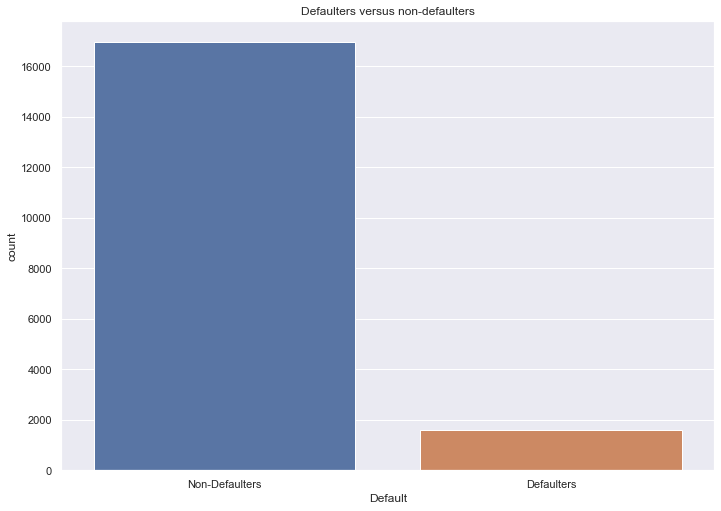

In [12]:
# Check proportion of defaulters/non-defaulters
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x='Default', data=accepts_df)
plt.title('Defaulters versus non-defaulters')
ax.set_xticklabels(['Non-Defaulters','Defaulters'])


In [13]:
# Drop mobile_number feature as it only has value of 1 for all obs
accepts_df.drop(columns=['mobile_number'],inplace=True)
# List comprehension for creating lists of cat cols and num cols
categorical_cols = [col for col in accepts_df.columns if accepts_df[col].dtype == 'object']
numerical_cols = [col for col in accepts_df.columns if col not in categorical_cols]

rejects_df.drop(columns=['mobile_number'],inplace=True)
categorical_cols_rejects = [col for col in rejects_df.columns if rejects_df[col].dtype == 'object']
numerical_cols_rejects = [col for col in rejects_df.columns if col not in categorical_cols_rejects]


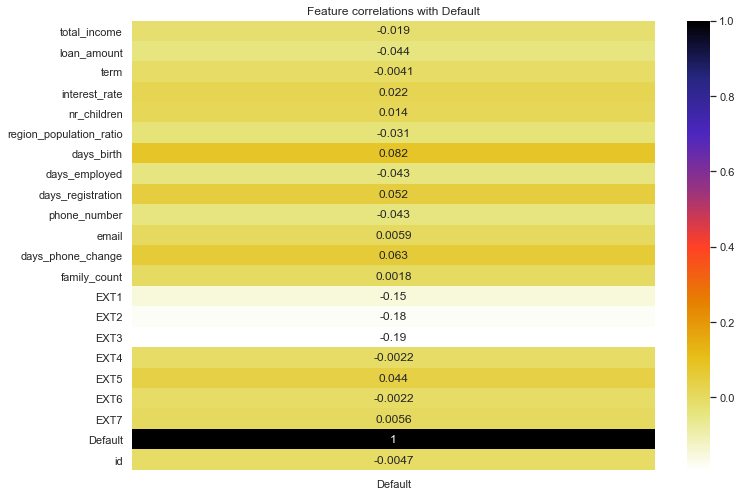

In [14]:
# Create correlation heatmap to examine correlations between num features and target
num_corrs = accepts_df[accepts_df[numerical_cols].columns[:]].corr()['Default'][:]
feature_labels = num_corrs.index
num_corrs = np.asarray(num_corrs).reshape(22,1)
sns.heatmap(num_corrs, annot=True, cmap=plt.cm.CMRmap_r,yticklabels=feature_labels,xticklabels=['Default'])
plt.title('Feature correlations with Default')
plt.show()

In [15]:
def contingence_2_chi_test(df,list_cats,target_var):
    """
    creates contingency table, plots heatmap of contingencies, comput chisquared test stat
    Args: dataframe, list of categorical features, and string corresponding to target variable of df
    returns: zipped list of feature name and corresponding p value from chi squared test 
    """
    # Initiate empty list to store chisquare p vals in
    feature_pvalue = []
    for col in list_cats:
        # Calculate contingency table with tv
        cont_tab_pct = pd.crosstab(accepts_df[col],accepts_df[target_var],normalize='index')
        # Plot heatmap of contingencies 
        plt.figure(figsize=(12,8))
        sns.heatmap(cont_tab_pct,annot=True,cmap='YlGnBu',xticklabels=['Non-default','Default'])
        plt.title(f'{col} contingency table Default')
        plt.show()
        c, p, dof, expected = chi2_contingency(cont_tab_pct)
        feature_pvalue.append(p)
    zipped_lists = zip(list_cats, feature_pvalue) 
    chi_pvalue_zip = list(zipped_lists)
    return(chi_pvalue_zip)
        

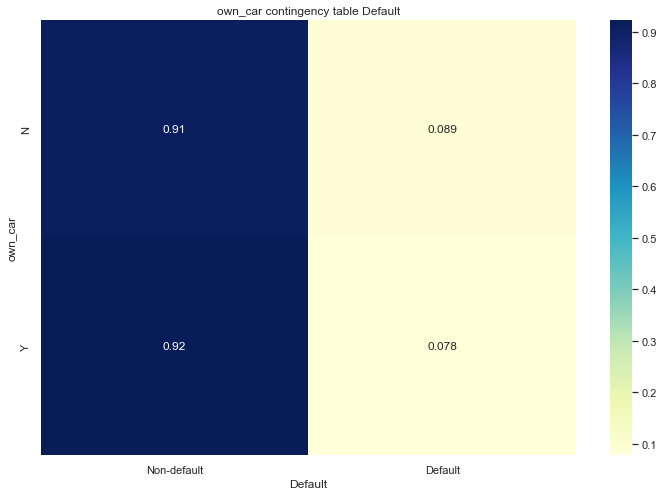

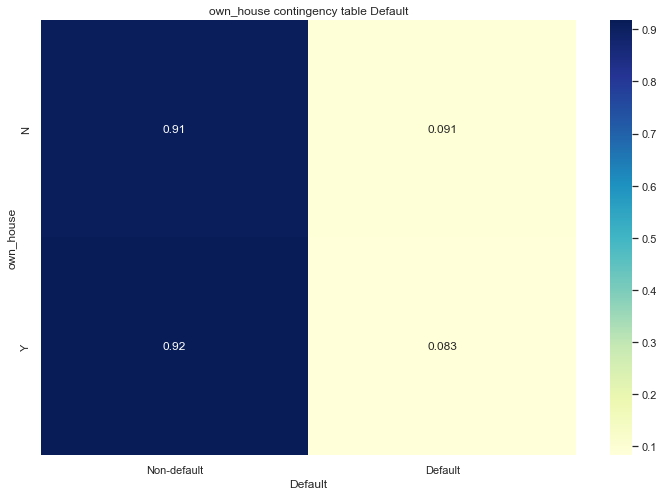

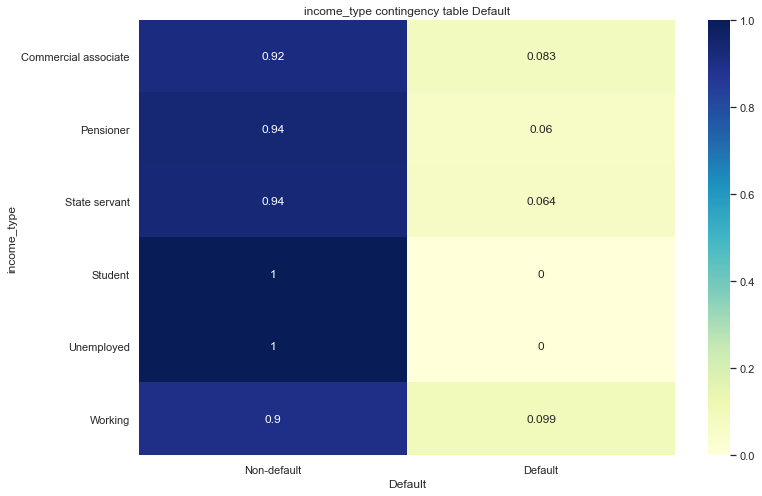

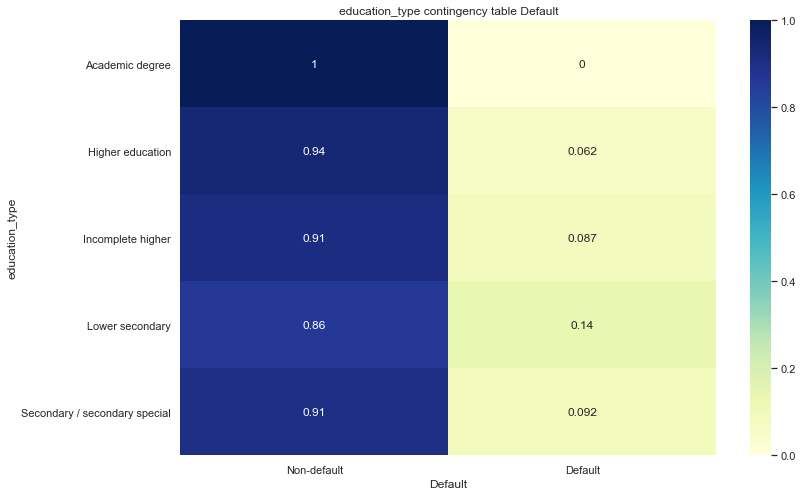

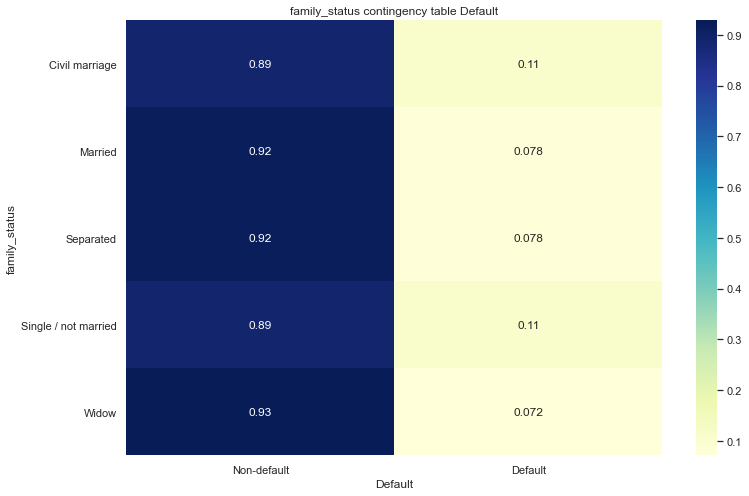

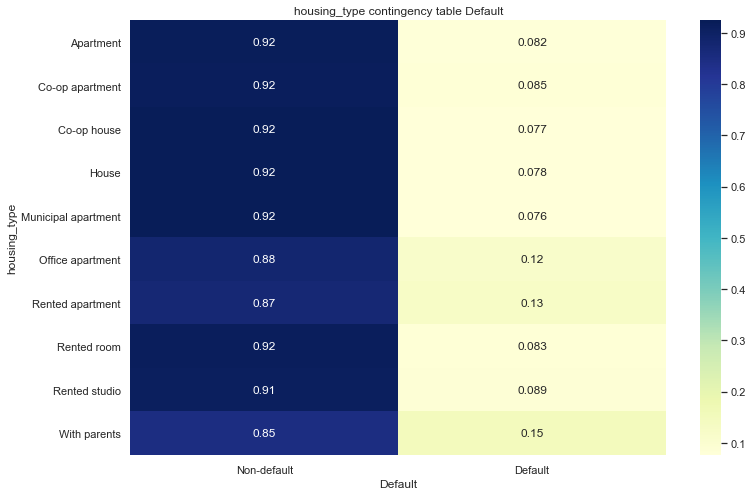

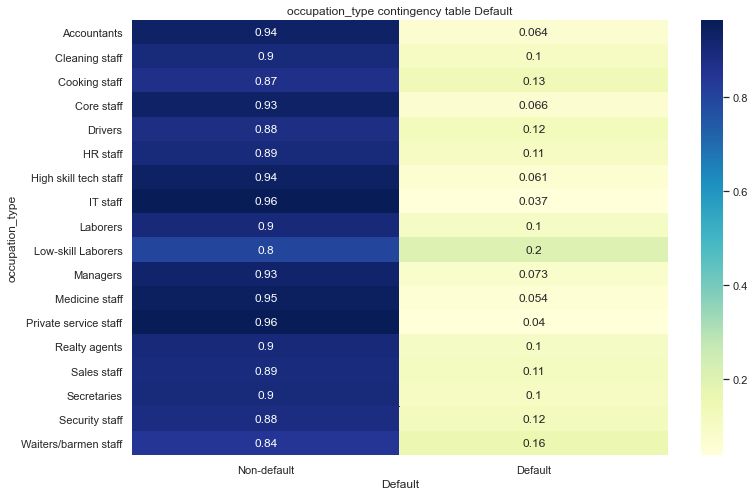

[('own_car', 0.011580953492628936),
 ('own_house', 0.01268207632133812),
 ('income_type', 0.9993026049464567),
 ('education_type', 0.9974770950908222),
 ('family_status', 0.9999663419147864),
 ('housing_type', 0.999999994260726),
 ('occupation_type', 0.9999999999976402)]

In [16]:
contingence_2_chi_test(accepts_df,categorical_cols,'Default')

In [17]:
# Visualize distribution of numeric_cols for determining need for discretization
# for col in numerical_cols:
#     plt.hist(accepts_df[col])
#     plt.title(col)
#     plt.show()

### Preprocessing

While preprocessing is a bit ubiquitous within this notebook, this location contains some of the critical initial instances of preprocessing procedures such as:

* **Outlier detection and removal**

Outliers were only removed from the `total_income` and `loan amount` features. This was determined given these columns show the largest spread or variance visible in the application of the Pandas `describe()` method in the EDA section. Additionally, it makes intuitive sense that individuals with very high income and or large loan applications demonstrate outlier behavior unrepresentative of the larger population. The potential for these observations biasing the training data is only exacerbated by the fact that for the time being, only accepted credit loan application data is being considered. Therefore, outliers for these columns were removed. The `outlier_removal` function below excludes observations with `total_income` and `loan amount` z-scores with an absolute value greater than three. *This decision showed to improve AUC scores in post-hoc analysis*.

* **Discretization of numeric variables**

All non-binary numerical features were discretized into 10-bin quantiles to enable WoE encoding which requires discrete input features. Binary features are already discrete hence there is no need for discretization clearly. 

* **Odds-based grouping for high-cardinality categoricals**

For those variables with a cardinality of greater than ten, the `step_OBG` function was invoked to rebin the categorical levels of these features optimally for WoE encoding. This form of rebinning merges those categorical levels with the lowest odds or incidence rate. This reduces unnecessary complexity, while yielding more concentrated WoE encodings in the long run. The minimum bin size used was three as this value proved to yield the best results with regard to AUC performance.  

* **Feature selection using information value (IV from here onwards)**

In order to report as concisely as possible, defining WoE and IV upfront is helpful. *WoE corresponds to ln(non-defaulters/defaulters)* for each discrete value of a feature. It can be thought of as a compression of the incidence rate per discrete level of a feature. *IV on the other hand is calculated using the WoE and is defined as: $\sum_{}$(% of non-defaults - % defaults) * WoE. 

IV therefore is a useful criterion for determining which features are relevant for differentiating defaulters and non-defaulters. The `iv_calc` function calculates the IV value across all features in an input dataframe and returns the feature name and its respective IV value. These values are then plotted in a bar plot to visually observe the differences in IV magnitude. Some rules of thumb when it comes to the interpretation of IV values are: Values between .02-1 have weak predictive power, .1-.3 have medium predictive power, and .3-.5 have strong predictive power.

The plot and corresponding IV values make it clear that only `EXT2` and `EXT3` can be considered to have strong predictive power, `EXT1` having medium predictive power, and all other features have either weak predictive power or virtually none whatsoever. However, leniency towards lower IV features was used when selecting features. Instead of excluding all features with an IV lower than .02, only those with an IV of virtually zero (`term`,`family_count`,`email`,`nr_children`,`EXT5` and `EXT17`) were excluded. The logic for this decision is that given the low incidence rate, the IV should be considered a little more critically due to their deflated magnitudes. Therefore, to maintain the highest level of predictive accuracy the first 18 variables sorted in descending order of IV magnitude were subset and selected as the features to model. *This assumption was validated through post-hoc experimentation*. 

* **Weight-of-Evidence encoding**

Next the `WOEEncoder()` class from the `category_encoders` module was applied to the rejected credit loan applications dataset in preparation for the reject inference application. Thanks to the previous preprocessing steps in discretization and rebinning the output of the encoder is as expected with all features encoded and the bins consolidated. 

* **`Train/test` splitting**

Finally, to enable future evaluation of prediction accuracy a train/test split is applied with a train/test ratio of 75/25.


<AxesSubplot:>

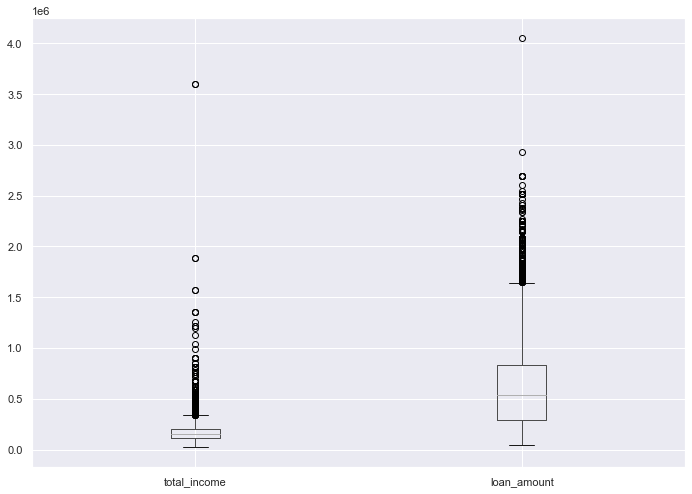

In [18]:
# Outlier detection accepts df
accepts_df.boxplot(column=['total_income',
 'loan_amount'])

<AxesSubplot:>

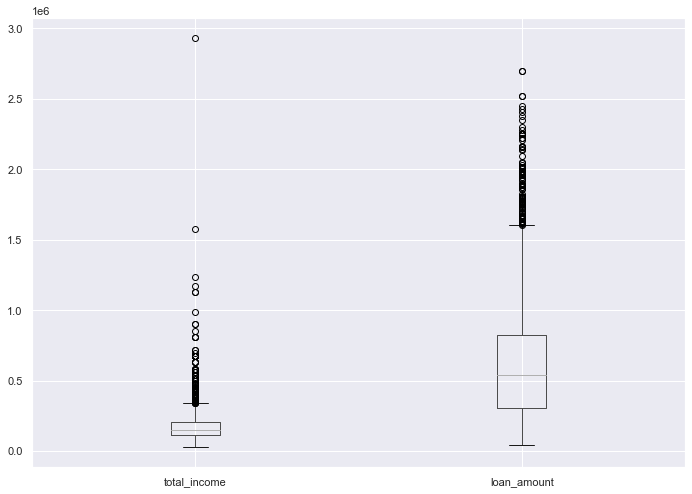

In [19]:
# Outlier detection accepts df
rejects_df.boxplot(column=['total_income',
 'loan_amount'])

In [20]:
def outlier_removal(df,z_score_cutoff,outlier_cols=['total_income','loan_amount']):
    """
    Computes z_score for columns within dataframe. Excludes outliers based on z_score cutoff from df.
    args: dataframe, z-score cutoff value, cols which to consider for oultier removal
    returns: dataframe with outliers excluded
    
    Code adapted from in-class notebook
    """
    # compute zscores
    zscores = df[outlier_cols].apply(stats.zscore)

    # zscores greater or equal 3 are set to False
    mask = np.all(np.abs(zscores.values) < z_score_cutoff, axis=1)

    # remove masked rows
    df_zscore = df.iloc[mask].reset_index(drop=True)

    print(f"Removed {df.shape[0]-df_zscore.shape[0]} rows ...")

    df = df.iloc[mask].reset_index(drop=True)
    return(df)



In [21]:
accepts_df = outlier_removal(accepts_df,3)
rejects_df = outlier_removal(rejects_df,3)

Removed 318 rows ...
Removed 208 rows ...


In [22]:
def discretize_numerics(df,q=10,binary_vars=['Default','phone_number','email','EXT4','EXT6','id'],numerical_cols=numerical_cols):
    to_discretize = [col for col in numerical_cols if col not in binary_vars]
    # Discretization for all numeric features
    for col in to_discretize:
        df[col] = pd.qcut(df[col], q=q, labels=False, duplicates='drop').astype('str')
    return(df)
    

In [23]:
accepts_df = discretize_numerics(accepts_df,q=10)
rejects_df = discretize_numerics(rejects_df,q=10)

In [24]:
def step_OBG(var, target, max_delta=0.05, min_bins=3):
    """
    Adapted from class notebook
    Odds based grouping for categorical variables (recursive function) 
    """

    # convert variable to string
    var = var.astype(str).copy()

    # check stopping criteria: min bins
    if len(np.unique(var)) <= min_bins:
        return var

    # compute odds
    ct = pd.crosstab(var, target)
    odds = np.array(ct.iloc[:,1] / (ct.iloc[:,0] + ct.iloc[:,1]))
    diff = np.abs(np.triu(np.subtract.outer(odds, odds)))
    diff[diff==0] = np.inf

    # check stopping criteria: max_delta
    if np.min(diff) > max_delta:
        return var

    # get index for levels with min delta
    a, b = np.unravel_index(diff.argmin(), diff.shape)
    
    name_a, name_b = list(ct.index[[a,b]])
    name_update = f"{name_a}_{name_b}"

    # group levels of variable
    var_update = var.replace(name_a, name_update).replace(name_b, name_update)

    # recursive call
    return step_OBG(var_update, target, max_delta, min_bins)

In [25]:
high_cardinality_cols = [col for col in categorical_cols if len(accepts_df[col].unique()) >= 10]

for col in high_cardinality_cols:
    accepts_df[col] = step_OBG(accepts_df[col],accepts_df['Default'],max_delta=0.5,min_bins=3)
    rejects_df[col] = step_OBG(accepts_df[col],accepts_df['Default'],max_delta=0.5,min_bins=3)

In [26]:
rejects_df.head()

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,id
0,9,7,5,0,N,Y,0,Commercial associate,Higher education,Married,...,Accountants_Core staff_nan_Managers_High skill...,1,nan,3.0,8.0,0,0,0,0,0
1,1,5,3,3,N,Y,0,Working,Secondary / secondary special,Married,...,Accountants_Core staff_nan_Managers_High skill...,0,3.0,8.0,5.0,0,0,0,0,1
2,8,7,5,3,Y,Y,0,Working,Secondary / secondary special,Single / not married,...,Accountants_Core staff_nan_Managers_High skill...,0,0.0,3.0,8.0,0,0,0,0,2
3,3,7,4,5,N,N,0,Commercial associate,Secondary / secondary special,Married,...,Accountants_Core staff_nan_Managers_High skill...,0,nan,0.0,3.0,0,0,0,0,3
4,0,7,1,1,N,N,0,Pensioner,Secondary / secondary special,Single / not married,...,Accountants_Core staff_nan_Managers_High skill...,0,nan,4.0,9.0,0,0,0,0,4


In [27]:
# Encode 'Y'/'N' cols to binary encodings
accepts_df['own_car'] = np.where(accepts_df['own_car']=='Y',1,0)
accepts_df['own_house'] = np.where(accepts_df['own_house']=='Y',1,0)

rejects_df['own_car'] = np.where(rejects_df['own_car']=='Y',1,0)
rejects_df['own_house'] = np.where(rejects_df['own_house']=='Y',1,0)

In [28]:
def iv_calc(df):
    ivs = []
    vars = []
    for col in df.columns:
        ct = pd.crosstab(df[col], df["Default"])
        ct.columns = ["Non-Default", "Default"]
        ct['Dist_Good'] = ct['Non-Default'] / np.sum(ct['Non-Default'])
        ct['Dist_Bad'] = ct['Default'] / np.sum(ct['Default'])
        ct['WOE'] = np.log(ct['Dist_Good'] / ct['Dist_Bad'])
        ct['IV'] = (ct['Dist_Good'] - ct['Dist_Bad']) * ct['WOE']
        iv = np.sum(ct['IV'])
        if iv == np.inf:
            continue
        ivs.append(iv)
        vars.append(col)
        zipped_lists = zip(vars,ivs)
        vars_ivs = list(zipped_lists)
    return(vars_ivs)

In [29]:
iv_features = iv_calc(accepts_df)
iv_features

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[('total_income', 0.016270895353129367),
 ('loan_amount', 0.06029845725765284),
 ('term', 0.001690264047560698),
 ('interest_rate', 0.01015158422591468),
 ('own_car', 0.003958947910699527),
 ('own_house', 0.0024285913353903083),
 ('nr_children', 0.00041053180814856695),
 ('family_status', 0.02723681594913394),
 ('housing_type', 0.03606572417517214),
 ('region_population_ratio', 0.03172507024176338),
 ('days_birth', 0.09223680480258899),
 ('days_employed', 0.12160339855241169),
 ('days_registration', 0.046446108375997525),
 ('phone_number', 0.02480139300275252),
 ('email', 0.0007533222592764642),
 ('days_phone_change', 0.0674174253370973),
 ('occupation_type', 0.014033829054189243),
 ('family_count', 0.0012644110883088186),
 ('EXT1', 0.15422826043408203),
 ('EXT2', 0.3902347706564453),
 ('EXT3', 0.36587698758289666),
 ('EXT5', 0.0),
 ('EXT7', 0.0)]

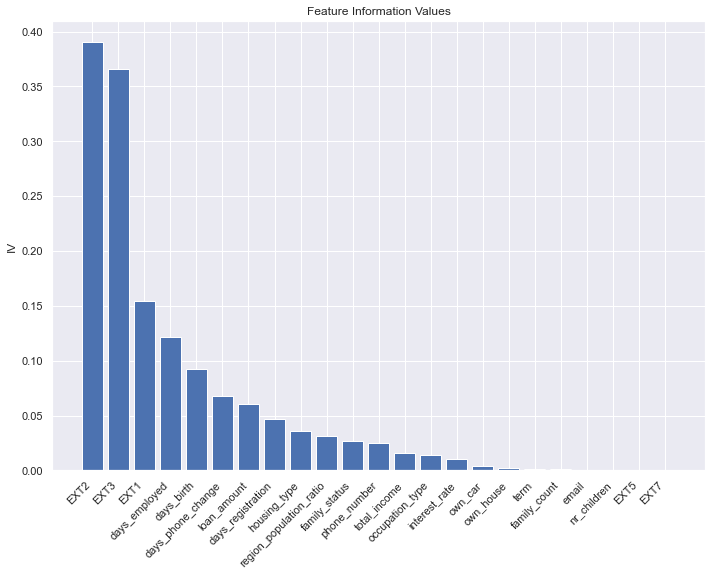

In [30]:
# Sort features in-place from highest to lowest
iv_features.sort(key=lambda x: x[1], reverse=True) 

# Save the features and their respective IVs separately
# Switch the tuples to go from most frequent to least frequent 
feature = list(zip(*iv_features))[0]
iv = list(zip(*iv_features))[1]
x_pos = np.arange(len(feature)) 

# Plot IV by feature 
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.bar(feature, iv)
plt.xticks(x_pos, feature) 
plt.ylabel('IV')
plt.title('Feature Information Values')
ax.set_xticklabels(feature, rotation = 45, ha="right")
plt.show()

In [31]:
# Keep all features besides those with zero IV
features_to_keep = list(list(zip(*iv_features[:18]))[0])
features_to_keep.append('id')
rejects_df = rejects_df[features_to_keep]
features_to_keep.append('Default')
accepts_df = accepts_df[features_to_keep]

In [32]:
# Cast binary features to string for WoE encoding
cols_still_num = [col for col in accepts_df.columns if accepts_df[col].dtype != 'object'][:1] # sliced to exclude Default (tv)

for col in cols_still_num:
    accepts_df[col] = accepts_df[col].astype('str')
    rejects_df[col] = rejects_df[col].astype('str')



In [33]:
# Create instance of WoE encoder
woe_encoder = WOEEncoder()

woe_encoder.fit(X=accepts_df.iloc[:,0:19], y=accepts_df['Default'])
rejects_df = woe_encoder.transform(X=rejects_df)

In [34]:
# Define X and y
X,y = accepts_df[[col for col in accepts_df.columns if col != 'Default']],accepts_df['Default']

In [35]:
random_state = 123
# Train test split
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X,y,test_size=0.25,random_state=random_state,stratify=y) # Distinguish X_train, y_train as pre-reject inference

### Cost-Based Evaluation Functionality

Within this portion of the notebook all important functionality for estimating the operational costs and risk associated with credit loan application acceptance or rejection based on model prediction outcomes is defined. 

**Important constants:**
* *Loss given default `lgd`*: The monetary amount of the loan lost by the bank if the loaner defaults.
* *Risk-free interest rate `ir_rf`*: is the theoretical ROI of a provided loan with zero risk. 

* **Financial/Accounting Functions**: 

First off, the functions `A`,`PV`, and `FV` abstract the measures of loan annuity, present value, and face value by developing their respective equations into code. 

* **Cost of misclassification (Type I and Type II errors) functions**:

The `cost_FP` function calculates the financial cost of a false positive or type I error. In this case, the loan applicant is incorrectly classified as a defaulter and therefore has their loan rejected. Therefore, the financial loss is estimated as the present value of the loan, calculated with the annuity, risk-free interest rate, and term in years minus the loan amount. We essentially lose out on the opportunity to earn the profit made from the `ir_rf` given that the loaner in actuality is a good one and would not default. Therefore, this cost is incurred for every false positive prediction outcome.  

The `cost_FN` function calculates the cost of the inverse scenario. If the model classifies the applicant as someone who's unlikely to default and therefore who's credit loan is accepted by the bank and who then actually turns out to default on the loan in the future. The cost incurred by this misclassification is equivalent simply to the loan amount times the `lgd`. 

* **Calculating the cost-matrix:** 

The cost-matrix is a dataframe object that stores the cost of false positive and false negative classification for each observation or credit applicant within the specified dataset. There is no cost for accurate predictions and therefore no need for including them within the dataframe. The `get_cost_matrix` function takes care of computing the cost-matrix when provided with a dataset as input. The dataset of input must be in its raw form instead of the WoE encoding transformed dataframes, to access the loan, interest, and term values. Some manipulation was performed in order to return the cost-matrix for the test or OOS set that will be used to evaluate model predictions. 

* **Total-cost calculation function:**

The `total_cost` function takes as input the actual `Default` labels of the dataset, the prediction for the dataset, and the `cost_FP` and `cost_FN` from the cost-matrix for the respective dataset and calculates the sum of both costs across the entire dataset. This function's output is now a critical criterion for judging the performance of the underlying modeling used to build the credit scorecard alongside the AUC. 

In [36]:
# Financials functions source from class notebook -- no need to reinvent the wheel here... 
# Annuity
def A(am, ir_c, n):
    return am * (ir_c*(1+ir_c)**n) / ((1+ir_c)**n - 1)

# Present Value
def PV(A, ir_rf, n):
    return A * (1-1/((1+ir_rf)**n)) / ir_rf

# Future Value
def FV(am, ir, n):
    return am * (1+ir)**n

# Cost of false positive
def cost_FP(am, n, ir_c, ir_rf=0.015):
    return PV(A(am,ir_c,n),ir_rf,n) - am

# Cost of false negative 
def cost_FN(am, lgd=0.75):
    return am*lgd

In [37]:
def get_cost_matrix(dataset,ir_rf,lgd):
    """
    Returns dataframe with cost of false positive, false negative, true positive, and true negative for every observation of the input dataframe.
    args: input dataframe, risk free interest rate as a float, and loss given default ratio as a float. 
    """
    cFP = []
    cFN = []
    for index,row in dataset.iterrows():
        cFP.append(cost_FP(row['loan_amount'],(row['term']/12),row['interest_rate']/100,ir_rf))
        cFN.append(cost_FN(row['loan_amount'],lgd))
    dict_costs = {
    'cFP':cFP,
    'cFN':cFN}
    cost_mat = pd.DataFrame(dict_costs)
    return(cost_mat)

In [38]:
# Create a df of all the raw data from both accepts and rejects
full_set_raw = pd.concat([accepts_df_raw,rejects_df_raw],axis=0)

# Create raw data X_test dataframe to calculate costs
ids_X_test = X_test['id'].reset_index(drop=True).to_list()
mask = accepts_df_raw['id'].isin(ids_X_test)
X_test_raw = accepts_df_raw[mask]

In [39]:
# Get X_test cost matrix 
X_test_cm = get_cost_matrix(X_test_raw,.015,.75)
X_test_cm

,cFP,cFN
0,11971.598192,168750.00
1,19928.455406,371918.25
2,5397.542869,202500.00
3,4434.663095,111273.75
4,22659.930071,283635.00
...,...,...
4553,8826.216412,364230.00
4554,13985.428813,243000.00
4555,10908.994127,337500.00
4556,24097.007609,622660.50


In [40]:
def total_cost(true, pred, cFN, cFP):
    """
    Returns total cost in Euros of using a models prediction outcomes for credit application acceptance or rejection.
    args: actual labels of the models inputs as an array, predicated lables as an array, cTP, cFN, cFP, cTN
    columns of cost matrix for respective dataset as series. 

    Adapted form in-class notebook
    """
    tc = true*(pred*0+(1-pred)*cFN)+(1-true)*(pred*cFP+(1-pred)*0)
    tc = sum(tc.fillna(0))
    return tc

### Reject inference/Modeling

* **Probability Cutoff Selection:**

The reject inference technique can be broken down into the following algorithm: 

* 1) Fit logistic regression to `X_train_orig` and `y_train_orig` which correspond to the X_train and y_train ascertained from the train/test split applied to the accepted dataset. 
* 2) Make predictions on the rejected dataframe (with all the necessary transformations discretization, OBG rebinning for high-cardinality features, and WoE all exactly as applied on the accepted applicants data), using the `predict_proba` method so that predictions are produced in the form of probabilities with a numpy array. 
* 3) Based on a predetermined probability cutoff value, transform these floating point probability values to binary target labels. 
* 4) Concatenate the `X_train_orig` dataframe containing the train partition of the accepted applicants data and the full set of rejected applicants data and the `y_train_orig` and newly created `rejects_label` arrays respectively to form a new `X_train` and `y_train`. 
* 5) Hyperparameter tuning/make final predictions. 

The predicted probabilities found when applying the logistic regression on the `rejects_df` are quite low. This checks out because of the low incidence-rate within the `accepts_df`, and given that the model was trained on these observations, it's logical that not many predicted probabilities have a high value. Additionally, given that the number of positive response predictions (defaulters) among the credit applicants within the `rejects_df` is determined by the selected threshold, having a data-driven method of selecting this cutoff threshold is a good idea. 

The `select_rej_inf_cutoff` function exists to try to help make this decision. It essentially sticks the reject inference "algorithm" steps listed above into a for loop and allows the user to pass a range of cutoffs that the function will iterate through. On each iteration, the AUC, total cost, and F1-score determined when using the *ith* cutoff probability are each appended to respective lists. Finally, as a side effect the function plots three different elbow plots. One for the AUC, one for the total cost, and one with the F1-scores with the cutoff threshold values as the horizontal axes of all three plots. 

When invoking this function the value range passed to the function was 0-1 in increments of 0.15. Observing the plots shows that AUC peaks at a value of 0.72 at the cutoff of 0.3 and then more or less converges at around .7 as the cutoff probability approaches one. As for total cost, it peaks at a value of roughly 5 million at threshold around .1 and then trends downwards until it converges at a value of 4.4 million from cutoff of .6 onwards. 

The plot of the F1-score was used to offer another performance metric optimal for imbalanced data and because in this case a false negative is normally more costly but false positives in some cases can come at almost an equivalent cost. Given the F1-score is the harmonic mean of precision and recall, this makes for a great third metric to compare with. F1-score plot peaks at a value of 0.26 at a probability cutoff of approximately .19. 

While this function elucidates how sensitive the cost, AUC, and F1 are to the threshold value, it is important to think critically about why this is the case. The higher the threshold value is, the less predicted defaulters there are. This of course makes it easier to accurately predict non-defaulters and lowers the total cost, but blindly following this data will result in an overfit model given that underpredicting default within the rejected dataset does not help with the unbalanced target or make the model more robust and not overfit to accepted applicants. Therefore instead of selecting the threshold with the lowest total cost, I instead select the cutoff value of .19 given it has the highest F1-score, is amongst the AUC scores, and is not at the total cost’s peak. 

* **Modeling:** 

Now that the training data contains reject inference, two different models were applied in logistic regression and random forest. The final AUCs for these models are 0.714 and 0.718 and their associated operational costs are 53,606,626.58 and 53,114,808.375 respectively. Given the marginal difference in AUCs and total cost, the logistic regression model is selected given it produces coefficients that can be used to develop an easily interpretable scorecard which would likely be more intuitive when explained to stakeholders of the bank. 

In [41]:
# Applying WoE encoding on the Accepts data
woe_encoder = WOEEncoder()

X_train_orig = woe_encoder.fit_transform(X=X_train_orig, y=y_train_orig)
X_test = woe_encoder.transform(X=X_test)

In [42]:

def select_rej_inf_cutoff(X_train,y_train,cutoff_range=np.arange(0,1,.1)):
    """
    This model performs reject inference and iterates through cutoff thresholds for creating rejection labels based on model output, concatenates created labels to train set 
    fits logistic regression, evalutes predictions with AUC and total cost, appends AUCs and total costs to lists then makes an elbow plot for both these performance measures
    across the different cutoff thresholds.

    args: X_train, y_train, cutoff_range as a list or array

    returns: returns nothing but shows plots as a side effect
    """
    tcs = []
    aucs = []
    f1s = []
    for thresh in cutoff_range:
        lr = LogisticRegression()
        lr.fit(X_train_orig,y_train_orig)
        preds_reject = lr.predict_proba(rejects_df)

        rejects_labels = np.where(preds_reject[:,1] > thresh,1,0)
        X_train = pd.concat([X_train_orig, rejects_df], axis=0).reset_index(drop=True)
        y_train = np.append(y_train_orig, rejects_labels)

        lr = LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')
        lr.fit(X_train,y_train)
        test_preds_probs = lr.predict_proba(X_test)
        test_preds = lr.predict(X_test)
        
        fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds_probs[:, 1], pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucs.append(auc)

        tc = total_cost(y_test,test_preds,X_test_cm['cFN'],X_test_cm['cFP'])
        tcs.append(tc)
        
        f1 = metrics.f1_score(y_test,test_preds)
        f1s.append(f1)

    plt.plot(cutoff_range,aucs,'go--', linewidth=1.5, markersize=4)
    plt.title('AUC against cutoff threshold')
    plt.show()

    plt.plot(cutoff_range,tcs,'go--', linewidth=1.5, markersize=4)
    plt.title('Total cost against cutoff threshold')
    plt.show()
    
    plt.plot(cutoff_range,f1s,'go--', linewidth=1.5, markersize=4)
    plt.title('F1-score against cutoff threshold')
    plt.show()

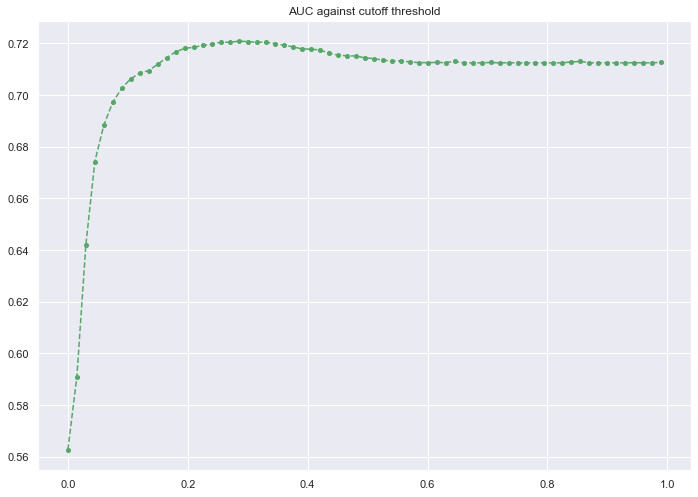

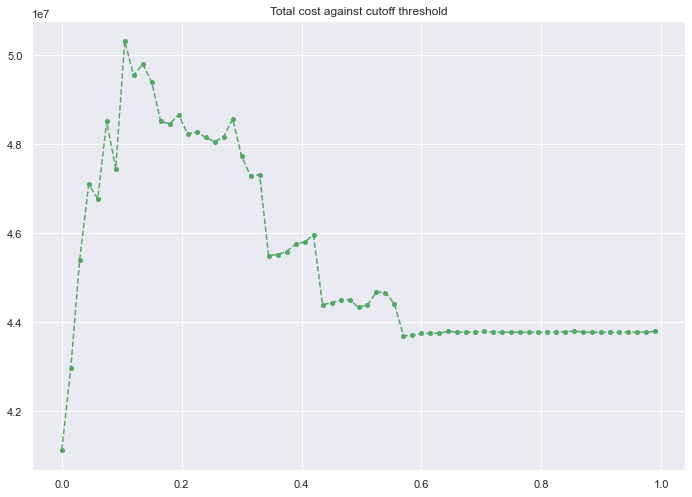

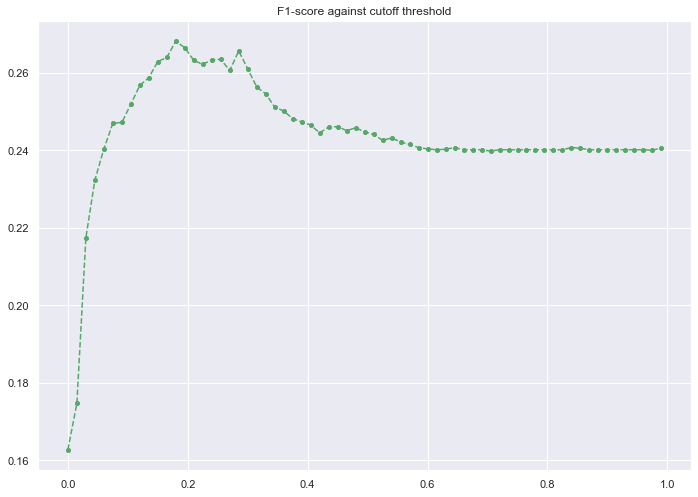

In [43]:
select_rej_inf_cutoff(X_train_orig,y_train_orig,cutoff_range=np.arange(0,1,.015))

In [44]:
lr = LogisticRegression()
lr.fit(X_train_orig,y_train_orig)
preds_reject = lr.predict_proba(rejects_df)

# Create labels for the rejects data using the cutoff threshold selected
rejects_labels = np.where(preds_reject[:,1] > 0.19,1,0)

# Concatenate accepts data with rejects data
X_train = pd.concat([X_train_orig, rejects_df], axis=0).reset_index(drop=True)
y_train = np.append(y_train_orig, rejects_labels)

In [45]:
# Tune hyperparameters
lr = LogisticRegression()

param_grid = {
               
            "solver":["liblinear"],
            'penalty': ['l1', 'l2'],
            'C':[0.25, 0.5, 1, 3], 
            "max_iter":[200,300,500,1000],
             "class_weight": ["balanced"]
            }
clf = GridSearchCV(lr, param_grid)
clf.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.5, 1, 3], 'class_weight': ['balanced'],
                         'max_iter': [200, 300, 500, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [46]:
clf.best_estimator_

LogisticRegression(C=0.25, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [47]:
# Create a full set of the raw data (accepts + rejects)
full_set_labels = pd.concat([full_set_raw['Default'],pd.Series(rejects_labels)],axis=0).reset_index(drop=True)
full_set_raw['Default'] = full_set_labels

full_set_raw = discretize_numerics(full_set_raw)

# Check information value for the full set
iv_features_full = iv_calc(full_set_raw)

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
iv_features_full

[('total_income', 0.012453010919588673),
 ('loan_amount', 0.02747677352505773),
 ('term', 0.0012059732998999828),
 ('interest_rate', 0.005778820324683975),
 ('own_car', 0.0017677334822589275),
 ('own_house', 0.0004374476376414946),
 ('nr_children', 0.0009677632826016554),
 ('family_status', 0.01848071057170654),
 ('housing_type', 0.018430354846150233),
 ('region_population_ratio', 0.021517096652827826),
 ('days_birth', 0.047955431379226296),
 ('days_employed', 0.04835747513979399),
 ('days_registration', 0.025110117183740215),
 ('mobile_number', 0.0),
 ('phone_number', 0.009861285271435158),
 ('email', 0.0008967783488658195),
 ('days_phone_change', 0.03981243183838992),
 ('occupation_type', 0.04711420491570907),
 ('family_count', 0.0009568577183953772),
 ('EXT1', 0.0682582987762228),
 ('EXT2', 0.19140142064460786),
 ('EXT3', 0.18656360818961568),
 ('EXT5', 0.0),
 ('EXT7', 0.0)]

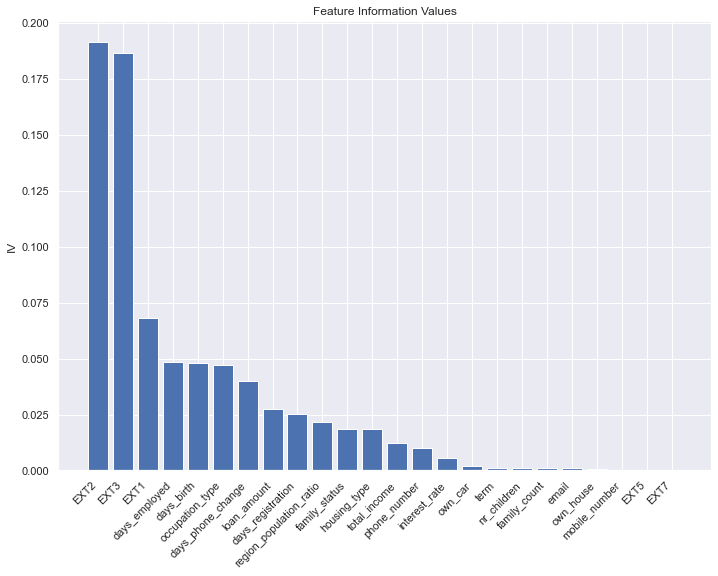

In [49]:
iv_features_full.sort(key=lambda x: x[1], reverse=True) 

# Save the features and their respective IVs separately
# Switch the tuples to go from most frequent to least frequent 
feature = list(zip(*iv_features_full))[0]
iv = list(zip(*iv_features_full))[1]
x_pos = np.arange(len(feature)) 

# Plot IV by feature 
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.bar(feature, iv)
plt.xticks(x_pos, feature) 
plt.ylabel('IV')
plt.title('Feature Information Values')
ax.set_xticklabels(feature, rotation = 45, ha="right")
plt.show()

In [50]:
# Drop id column used for keeping track of observations in the split
X_test.drop(columns=['id'],inplace=True)
X_train.drop(columns=['id'],inplace=True)

In [51]:
LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')
lr.fit(X_train,y_train)
test_preds_probs = lr.predict_proba(X_test)
test_preds = lr.predict(X_test)

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds_probs[:,1], pos_label=1)
metrics.auc(fpr, tpr)

0.7146494459521686

In [53]:
total_cost(y_test,test_preds,X_test_cm['cFN'],X_test_cm['cFP'])

53606626.58031024

In [54]:
# Run grid search for Random Forest Model
# rf = RandomForestClassifier()

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10, 20, 30, 40],
#     'max_features': [3,10],
#     'min_samples_leaf': [50,100],
#     'min_samples_split': [8, 10],
#     'n_estimators': [100, 200]
# }

# grid_search_rf = GridSearchCV(rf,param_grid)
# grid_search_rf.fit(X_train,y_train)

In [55]:
# grid_search_rf.best_estimator_

In [56]:
# Apply random forest
rf = RandomForestClassifier(max_depth=30, max_features=3, min_samples_leaf=100,
                       min_samples_split=8, random_state=random_state)
rf.fit(X_train,y_train)
test_preds_prob_rf = rf.predict_proba(X_test)
test_preds_rf = rf.predict(X_test)

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds_prob_rf[:,1], pos_label=1)
metrics.auc(fpr, tpr)

0.718525576337112

In [58]:
total_cost(y_test,test_preds_rf,X_test_cm['cFN'],X_test_cm['cFP'])

53114808.375

### Scoring

Now that the most recent instance of logistic regression above has been selected as the final scorecard model, the `score_func` function below develops the scores using a somewhat standardized procedure used in the credit scoring applications of many financial institutions. 

The function takes five parameters essential to deriving the final scores per applicant. The arguments correspond to the following information:

* `model`: The final model selected for scoring
* `df` The dataframe with the WoE encodings for the dataset that is being scored
* `target`: An ideal or target credit score value. Changing the value of this rescales the scores arbitrarily. 
* `target_odds`: The odds of being a good applicant required to receive the target score
* `pdo`: The pdo corresponds to the point differential required for the odds of being a good applicant to double.  

The scoring algorithm then works as follows: 

* 1) The dataframe of WoE is multiplied by the coefficients of the logistic regression model
* 2) The factor is calculated by dividing the `pdo` by the log(2) -- the larger the `pdo`, the larger the factor
* 3) The offset is calculated by multiplying the factor by the base 10 logarithm of the `target_ods` and therefore the larger the `target_odds`, the smaller the offset.
* 4) The score is then calculated as the factor multiplied by the product of the coefficients and the WoEs, plus the model's intercept term divided by the number of covariates. The value derived is then subtracted from the offset divided by the number of covariates. 

Upon calculating the scores for all applicants the function plots a scatter plot reflecting the cumulative distribution of scores as well as a histogram to give insight into the actual frequencies across different scores. 

The default arguments of the `score_func` function were selected specifically in the interest of having an interpretable and reliable outcome. The `target` score was selected to be 850 in order to maintain consistency with scales commonly used for credit scoring such as the FICO score. The `target_odds` is remarkably high due to the imbalance in the data. Therefore the odds of being a non-defaulter have to be on the order of thousands for the highest scores to correspond to the applicants with the least likelihood of being defaulters. Finally, the `pdo` was given a default value such that the factor value would remain high enough that the offset would create a normal distribution of scores. One can see by observing the side effect plots that the scores are distributed rather evenly validating the default argument selections. 

Finally, by taking the mean of every column within the `credit_scores` dataframe it is possible to interpret the average impact of these features on the final credit score of an applicant. Interestingly, the `own_house` has the highest average impact by a landslide at 83.32 followed by `own_car` at 36.9. Unconincendentally, these two variables were the only two categoricals to have a significant Chi-squared test P value from the EDA section of this project. The anonymized variables of `EXT1`-`EXT3` are the next three most impactful features on average, while all the remaining features impacts are similar around 20. These numbers have intuitive explanations for why they would impact likelihood of default and have pretty well-distributed impacts making this scorecard generalizable to new data this model will use to make predictions in deployment. Overall, this scorecard passes inspection and is ready for real-world application. 

In [59]:
def score_func(model,df, target=850, target_odds=4000, pdo=50):
    """
    Data-driven application scoring function.
    Inspired by: https://blogs.sas.com/content/subconsciousmusings/2019/01/18/building-credit-scorecards-using-statistical-methods-and-business-logic/
    """
    df_logit = df * model.coef_
    intercept = model.intercept_.item()
    params = df_logit.shape[1]

    factor = pdo / np.log(2)
    offset = target - factor * np.log(target_odds)

    # regression model predicts default, therefore: factor*logit is deducted from offset
    score  = offset/params - factor * (df_logit + intercept/params)

    # compute row sums (total score per applicant) and sort values
    sum_sort = np.sort(np.sum(score, axis=1))

    plt.scatter(sum_sort, np.cumsum(sum_sort)/sum(sum_sort))
    plt.title('Probability of being a Good credit applicant against credit score')
    plt.show()

    plt.hist(sum_sort)
    plt.title('Distribution of credit stores')
    
    return score

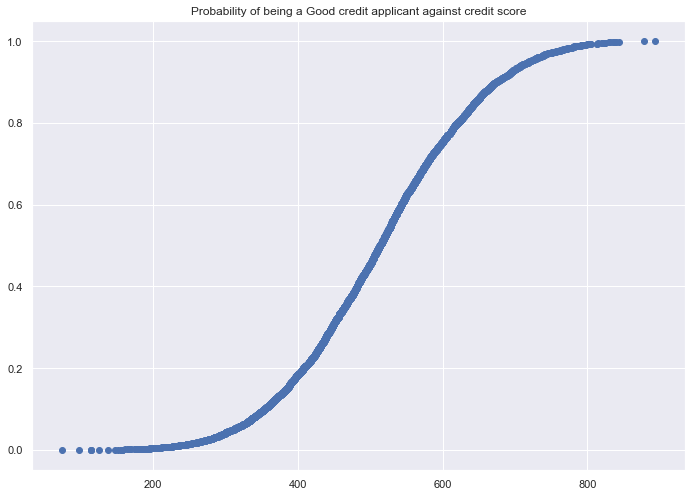

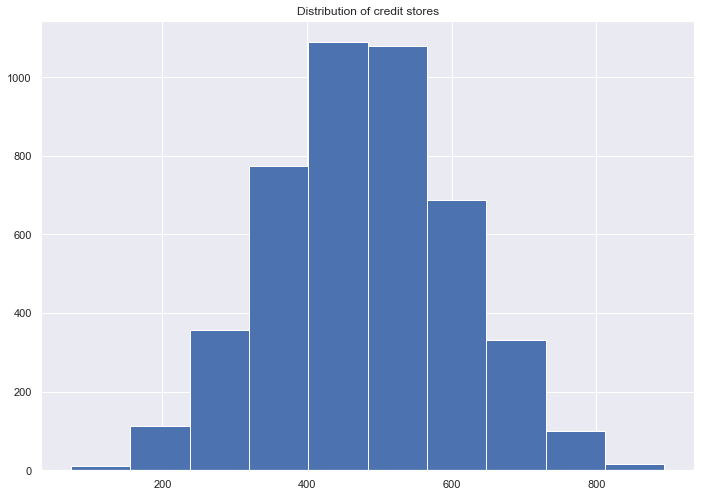

In [60]:
credit_scores = score_func(lr,X_test)

In [61]:
credit_scores.mean()

EXT2                       36.028618
EXT3                       35.685747
EXT1                       24.079772
days_employed              22.341837
days_birth                 20.803418
days_phone_change          20.364746
loan_amount                20.635359
days_registration          20.716029
housing_type               19.617298
region_population_ratio    20.146474
family_status              20.320379
phone_number               20.272272
total_income               19.991588
occupation_type            20.100370
interest_rate              20.017235
own_car                    36.947921
own_house                  82.327146
term                       19.721508
dtype: float64

### Sources: 

https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03

https://blogs.sas.com/content/subconsciousmusings/2019/01/18/building-credit-scorecards-using-statistical-methods-and-business-logic/